# Import Library

In [498]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Function Library

In [499]:
def miss_summary(df):
    """
    Returns a DataFrame with columns that have missing values, sorted in ascending order.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A summary DataFrame with column names, their missing value counts, 
                  and the percentage of missing values.
    """
    # Get missing value counts for each column
    missing_vals = df.isna().sum()

    # Filter for columns with missing values
    missing_vals = missing_vals[missing_vals > 0]

    # Compute missing percentage
    missing_percentage = (missing_vals / len(df)) * 100

    # Convert to DataFrame for better display and sort by missing count
    missing_vals_df = pd.DataFrame({
        "Missing Count": missing_vals,
        "Missing Percentage": missing_percentage.round(2)  # Round to 2 decimal places
    }).sort_values(by="Missing Count", ascending=True)

    return missing_vals_df

def impute_cols(imputer, column, df):
    """
    Imputes missing values in a specified column using a given imputer.

    Parameters:
    - imputer: A scikit-learn imputer instance (e.g., SimpleImputer).
    - column (str): Name of the column to impute.
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    np.ndarray: The imputed column as an integer array.
    """
    return imputer.fit_transform(df[[column]]).astype(int)

def miss_percent(num):
    """
    Computes the percentage of missing values in a dataset.

    Parameters:
    - num (int): Number of missing values.

    Returns:
    float: Percentage of missing values.
    """
    pct = round((num / 559877) * 100, 2)  # Assuming total dataset size of 559877
    return pct

# Data Preprocessing

In [500]:
date_cols = [
    'ClaimStartDt',
    'ClaimEndDt',
    'AdmissionDt',
    'DischargeDt',
    'DOB'
]
df = pd.read_csv('data/train_data_cleaned.csv', parse_dates= date_cols)
df.head()

/var/folders/6c/lknfcl0j3lb3skfwn995xkym0000gn/T/ipykernel_92963/4160855543.py:8: DtypeWarning: Columns (60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/train_data_cleaned.csv', parse_dates= date_cols)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7_LongDesc,ClmDiagnosisCode_7_ShortDesc,ClmDiagnosisCode_8_LongDesc,ClmDiagnosisCode_8_ShortDesc,ClmDiagnosisCode_9_LongDesc,ClmDiagnosisCode_9_ShortDesc,ClmDiagnosisCode_10_LongDesc,ClmDiagnosisCode_10_ShortDesc,Flag_Unknown_Procedures,Flag_Unknown_Diagnoses
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,Other and unspecified hyperlipidemia,Hyperlipidemia NEC/NOS,Secondary malignant neoplasm of other specifie...,Secondary malig neo NEC,"Acute kidney failure, unspecified",Acute kidney failure NOS,NaN,NaN,False,False
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,"Diabetes with neurological manifestations, typ...",DMII neuro uncntrld,"Hypertensive chronic kidney disease, unspecifi...",Hy kid NOS w cr kid I-IV,Unspecified essential hypertension,Hypertension NOS,NaN,NaN,False,False
4,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,"Diabetes with neurological manifestations, typ...",DMII neuro uncntrld,"Hypertensive chronic kidney disease, unspecifi...",Hy kid NOS w cr kid I-IV,Unspecified essential hypertension,Hypertension NOS,NaN,NaN,False,False


In [501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559877 entries, 0 to 559876
Data columns (total 84 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   BeneID                           559877 non-null  object        
 1   ClaimID                          559877 non-null  object        
 2   ClaimStartDt                     559877 non-null  datetime64[ns]
 3   ClaimEndDt                       559877 non-null  datetime64[ns]
 4   Provider                         559877 non-null  object        
 5   InscClaimAmtReimbursed           559877 non-null  int64         
 6   AttendingPhysician               558367 non-null  object        
 7   OperatingPhysician               115736 non-null  object        
 8   OtherPhysician                   200081 non-null  object        
 9   AdmissionDt                      41685 non-null   datetime64[ns]
 10  ClmAdmitDiagnosisCode            147187 non-

In [502]:
# Compute Hospital Stay Days (only for inpatient claims)
df.loc[:, "HospitalStayDays"] = (df["DischargeDt"] - df["AdmissionDt"]).dt.days
df.loc[:, "HospitalStayDays"] = df["HospitalStayDays"].fillna(0)

# Compute Claim Duration (days between claim start & end)
df.loc[:, "ClaimDuration"] = (df["ClaimEndDt"] - df["ClaimStartDt"]).dt.days
df.loc[:, "ClaimDuration"] = df["ClaimDuration"].fillna(df["ClaimDuration"].median())

# Compute Days Before Admission (difference between claim start and hospital admission)
df.loc[:, "DaysBeforeAdmission"] = (df["AdmissionDt"] - df["ClaimStartDt"]).dt.days
df.loc[:, "DaysBeforeAdmission"] = df["DaysBeforeAdmission"].fillna(0)

df.loc[:, "ClaimStartMonth"] = df["ClaimStartDt"].dt.month.astype(int)  
df.loc[:, "ClaimStartWeekday"] = df["ClaimStartDt"].dt.weekday.astype(int)
df.loc[:, "ClaimStartYear"] = df["ClaimStartDt"].astype(int)

df = df.sort_values(by=["BeneID", "ClaimStartDt"])
df.loc[:, "DaysSinceLastClaim"] = df.groupby("BeneID")["ClaimStartDt"].diff().dt.days
df["DaysSinceLastClaim"].fillna(0, inplace=True)

df.loc[:, "AgeAtClaim"] = (df["ClaimStartYear"] - df["DOB"].dt.year)

df.loc[:, "AgeGroup"] = pd.cut(
    df["Age"],
    bins=[0, 49, 60, 79, 97, 116],
    labels=["Under 50", "50-60", "61-79", "80-97", "98+"]
)

# Drop raw date columns (since we have extracted useful features)
df.drop(columns=["AdmissionDt", "DischargeDt", "ClaimStartDt", "ClaimEndDt", "DOB"], inplace=True)

/var/folders/6c/lknfcl0j3lb3skfwn995xkym0000gn/T/ipykernel_92963/2997401911.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["DaysSinceLastClaim"].fillna(0, inplace=True)


In [503]:
df = df.drop(columns= ['DOD'])

In [504]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 559877 entries, 352126 to 352125
Data columns (total 87 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   BeneID                           559877 non-null  object  
 1   ClaimID                          559877 non-null  object  
 2   Provider                         559877 non-null  object  
 3   InscClaimAmtReimbursed           559877 non-null  int64   
 4   AttendingPhysician               558367 non-null  object  
 5   OperatingPhysician               115736 non-null  object  
 6   OtherPhysician                   200081 non-null  object  
 7   ClmAdmitDiagnosisCode            147187 non-null  object  
 8   DeductibleAmtPaid                558956 non-null  float64 
 9   TotalClaims                      559877 non-null  int64   
 10  Gender                           559877 non-null  int64   
 11  Race                             559877 non-null  in

In [505]:
miss_summary(df)

,Missing Count,Missing Percentage
DeductibleAmtPaid,921,0.16
AttendingPhysician,1510,0.27
ClmDiagnosisCode_1_LongDesc,24546,4.38
ClmDiagnosisCode_1_ShortDesc,24546,4.38
ClmDiagnosisCode_2_ShortDesc,210349,37.57
ClmDiagnosisCode_2_LongDesc,210349,37.57
ClmDiagnosisCode_3_ShortDesc,325676,58.17
ClmDiagnosisCode_3_LongDesc,325676,58.17
OtherPhysician,359796,64.26
ClmDiagnosisCode_4_ShortDesc,401368,71.69


In [506]:
df.loc[:, "DeductibleAmtPaid"] = df["DeductibleAmtPaid"].fillna(0)

In [507]:
miss_summary(df)

,Missing Count,Missing Percentage
AttendingPhysician,1510,0.27
ClmDiagnosisCode_1_LongDesc,24546,4.38
ClmDiagnosisCode_1_ShortDesc,24546,4.38
ClmDiagnosisCode_2_ShortDesc,210349,37.57
ClmDiagnosisCode_2_LongDesc,210349,37.57
ClmDiagnosisCode_3_ShortDesc,325676,58.17
ClmDiagnosisCode_3_LongDesc,325676,58.17
OtherPhysician,359796,64.26
ClmDiagnosisCode_4_ShortDesc,401368,71.69
ClmDiagnosisCode_4_LongDesc,401368,71.69


In [508]:
df.loc[:, "AttendingPhysician"] = df.groupby("Provider")["AttendingPhysician"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [509]:
miss_summary(df)

,Missing Count,Missing Percentage
ClmDiagnosisCode_1_LongDesc,24546,4.38
ClmDiagnosisCode_1_ShortDesc,24546,4.38
ClmDiagnosisCode_2_LongDesc,210349,37.57
ClmDiagnosisCode_2_ShortDesc,210349,37.57
ClmDiagnosisCode_3_ShortDesc,325676,58.17
ClmDiagnosisCode_3_LongDesc,325676,58.17
OtherPhysician,359796,64.26
ClmDiagnosisCode_4_ShortDesc,401368,71.69
ClmDiagnosisCode_4_LongDesc,401368,71.69
ClmAdmitDiagnosisCode,412690,73.71


In [510]:
df.loc[:, "OtherPhysician"] = df["OtherPhysician"].fillna("None")

In [511]:
miss_summary(df)

,Missing Count,Missing Percentage
ClmDiagnosisCode_1_LongDesc,24546,4.38
ClmDiagnosisCode_1_ShortDesc,24546,4.38
ClmDiagnosisCode_2_LongDesc,210349,37.57
ClmDiagnosisCode_2_ShortDesc,210349,37.57
ClmDiagnosisCode_3_ShortDesc,325676,58.17
ClmDiagnosisCode_3_LongDesc,325676,58.17
ClmDiagnosisCode_4_ShortDesc,401368,71.69
ClmDiagnosisCode_4_LongDesc,401368,71.69
ClmAdmitDiagnosisCode,412690,73.71
OperatingPhysician,444141,79.33


In [512]:
df['ClaimType'][df['ClmAdmitDiagnosisCode'].isna()].unique()

array(['Outpatient'], dtype=object)

In [513]:
df.loc[:, "ClmAdmitDiagnosisCode"] = df["ClmAdmitDiagnosisCode"].fillna("Not Applicable")

In [514]:
miss_summary(df)

,Missing Count,Missing Percentage
ClmDiagnosisCode_1_LongDesc,24546,4.38
ClmDiagnosisCode_1_ShortDesc,24546,4.38
ClmDiagnosisCode_2_LongDesc,210349,37.57
ClmDiagnosisCode_2_ShortDesc,210349,37.57
ClmDiagnosisCode_3_LongDesc,325676,58.17
ClmDiagnosisCode_3_ShortDesc,325676,58.17
ClmDiagnosisCode_4_ShortDesc,401368,71.69
ClmDiagnosisCode_4_LongDesc,401368,71.69
OperatingPhysician,444141,79.33
ClmDiagnosisCode_5_ShortDesc,451998,80.73


In [515]:
df['ClaimType'][df['OperatingPhysician'].isna()]

352126    Outpatient
352127    Outpatient
352128    Outpatient
352129    Outpatient
352131    Outpatient
             ...    
352120    Outpatient
352121    Outpatient
352122    Outpatient
352124    Outpatient
352125    Outpatient
Name: ClaimType, Length: 444141, dtype: object

In [516]:
df.loc[:, "OperatingPhysician"] = df["OperatingPhysician"].fillna("None")

In [517]:
miss_summary(df)

,Missing Count,Missing Percentage
ClmDiagnosisCode_1_LongDesc,24546,4.38
ClmDiagnosisCode_1_ShortDesc,24546,4.38
ClmDiagnosisCode_2_LongDesc,210349,37.57
ClmDiagnosisCode_2_ShortDesc,210349,37.57
ClmDiagnosisCode_3_LongDesc,325676,58.17
ClmDiagnosisCode_3_ShortDesc,325676,58.17
ClmDiagnosisCode_4_LongDesc,401368,71.69
ClmDiagnosisCode_4_ShortDesc,401368,71.69
ClmDiagnosisCode_5_ShortDesc,451998,80.73
ClmDiagnosisCode_5_LongDesc,451998,80.73


In [518]:
diag_cols = [col for col in df.columns if "ClmDiagnosisCode" in col]
df.loc[:, diag_cols] = df[diag_cols].fillna("No Diagnosis")

In [519]:
miss_summary(df)

,Missing Count,Missing Percentage
PrimaryProcedure_LongDesc,535362,95.62
PrimaryProcedure_ShortDesc,535362,95.62


In [520]:
proc_cols = [col for col in df.columns if "PrimaryProcedure" in col or "ClmProcedureCode" in col]
df.loc[:, proc_cols] = df[proc_cols].fillna("No Procedure")

In [521]:
miss_summary(df)

,Missing Count,Missing Percentage


In [522]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 559877 entries, 352126 to 352125
Data columns (total 87 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   BeneID                           559877 non-null  object  
 1   ClaimID                          559877 non-null  object  
 2   Provider                         559877 non-null  object  
 3   InscClaimAmtReimbursed           559877 non-null  int64   
 4   AttendingPhysician               559877 non-null  object  
 5   OperatingPhysician               559877 non-null  object  
 6   OtherPhysician                   559877 non-null  object  
 7   ClmAdmitDiagnosisCode            559877 non-null  object  
 8   DeductibleAmtPaid                559877 non-null  float64 
 9   TotalClaims                      559877 non-null  int64   
 10  Gender                           559877 non-null  int64   
 11  Race                             559877 non-null  in

In [523]:
df.head()

,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,TotalClaims,...,Flag_Unknown_Diagnoses,HospitalStayDays,ClaimDuration,DaysBeforeAdmission,ClaimStartMonth,ClaimStartWeekday,ClaimStartYear,DaysSinceLastClaim,AgeAtClaim,AgeGroup
352126,BENE100000,CLM126832,PRV57172,50,PHY383401,None,None,Not Applicable,0.0,1672,...,False,0.0,0,0.0,1,3,1231372800000000000,0.0,1231372799999998062,80-97
352127,BENE100000,CLM351838,PRV57172,70,PHY370909,None,PHY363377,Not Applicable,0.0,1672,...,False,0.0,0,0.0,5,6,1241913600000000000,122.0,1241913599999998062,80-97
352128,BENE100001,CLM229075,PRV55158,70,PHY383478,None,None,64880,0.0,669,...,False,0.0,0,0.0,3,3,1236211200000000000,0.0,1236211199999998061,80-97
352129,BENE100001,CLM258631,PRV54966,70,PHY347511,None,None,36401,0.0,1796,...,False,0.0,0,0.0,3,5,1237593600000000000,16.0,1237593599999998061,80-97
352130,BENE100001,CLM332544,PRV54890,90,PHY343317,PHY408367,PHY408367,78009,0.0,73,...,False,0.0,2,0.0,4,3,1241049600000000000,40.0,1241049599999998061,80-97


In [524]:
df.drop(columns= ['BeneID', 'ClaimID'], inplace= True)

In [525]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 559877 entries, 352126 to 352125
Data columns (total 85 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   Provider                         559877 non-null  object  
 1   InscClaimAmtReimbursed           559877 non-null  int64   
 2   AttendingPhysician               559877 non-null  object  
 3   OperatingPhysician               559877 non-null  object  
 4   OtherPhysician                   559877 non-null  object  
 5   ClmAdmitDiagnosisCode            559877 non-null  object  
 6   DeductibleAmtPaid                559877 non-null  float64 
 7   TotalClaims                      559877 non-null  int64   
 8   Gender                           559877 non-null  int64   
 9   Race                             559877 non-null  int64   
 10  RenalDiseaseIndicator            559877 non-null  object  
 11  State                            559877 non-null  in

In [526]:
from scipy.stats import skew

# Identify numerical columns
numerical_cols = [
    'InscClaimAmtReimbursed',
    'DeductibleAmtPaid',  
    'IPAnnualDeductibleAmt', 
    'OPAnnualDeductibleAmt'
]

# Compute skewness for each numerical column
skew_values = df[numerical_cols].apply(lambda x: skew(x.dropna()))

# Identify highly skewed columns (commonly |skew| > 0.75)
skewed_cols = skew_values[abs(skew_values) > 0.75].index.tolist()

# Display skewed columns
print("Highly Skewed Columns:", skewed_cols)

Highly Skewed Columns: ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt']


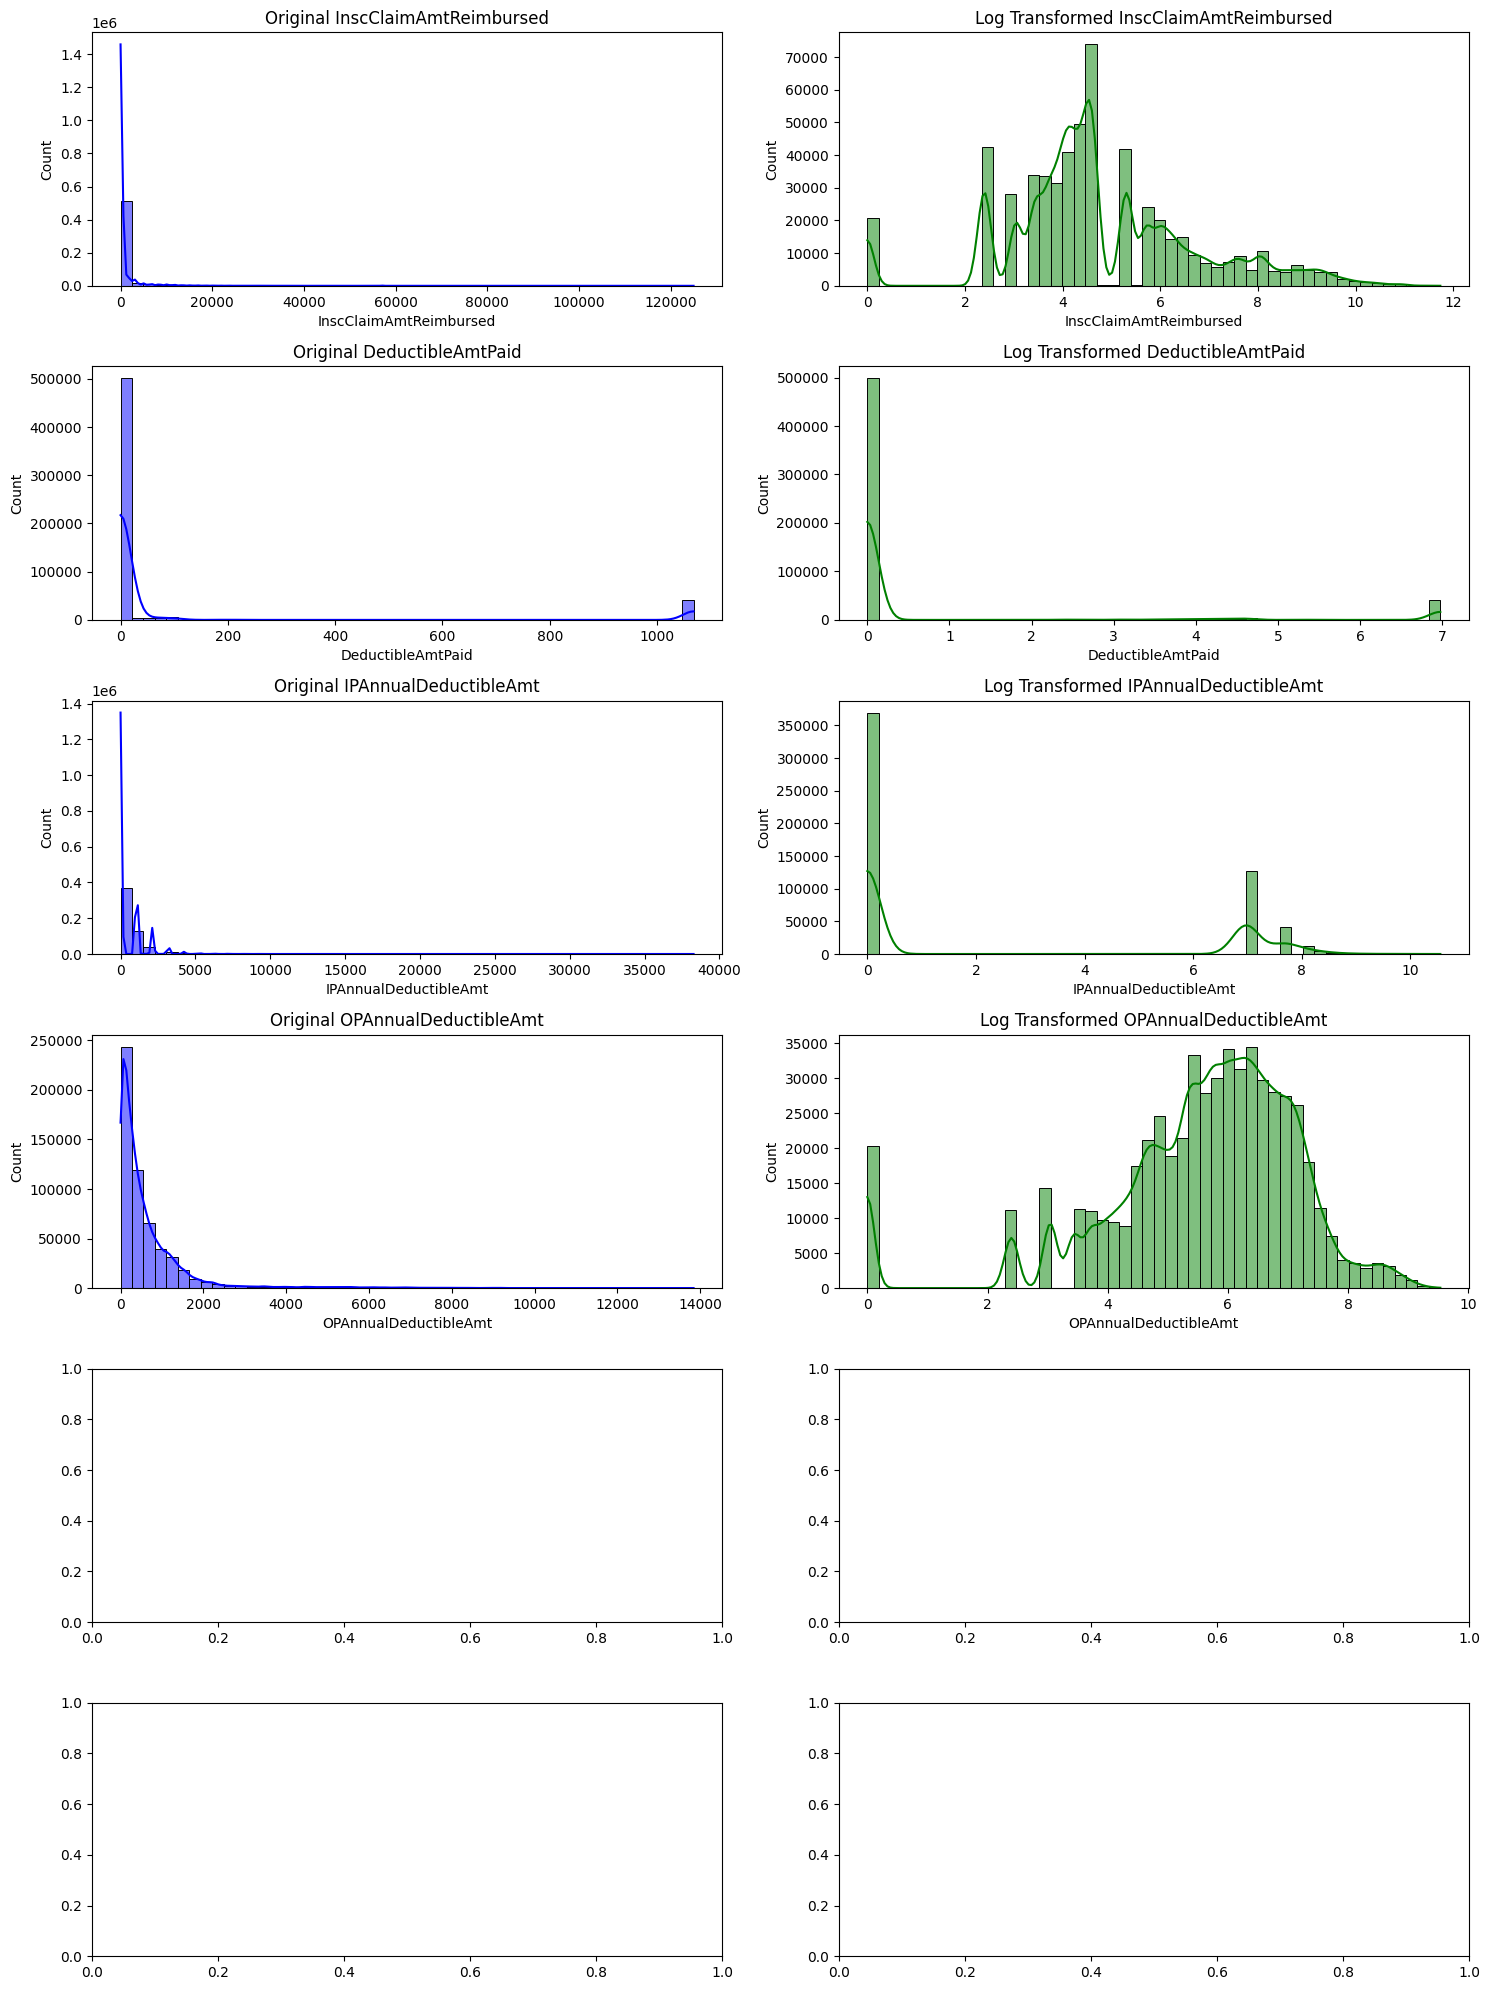

In [527]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

# Columns to transform
skewed_cols = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt']

# Set up a 6x3 subplot layout
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20))

for i, col in enumerate(skewed_cols):
    # Original Histogram
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i, 0], color="blue")
    axes[i, 0].set_title(f"Original {col}")
    
    # Log Transform Histogram (Adding 1 to avoid log(0) issues)
    log_transformed = np.log1p(df[col])
    sns.histplot(log_transformed, bins=50, kde=True, ax=axes[i, 1], color="green")
    axes[i, 1].set_title(f"Log Transformed {col}")
    
   
# Adjust layout
plt.tight_layout()
plt.show()


In [528]:
df['InscClaimAmtReimbursed'] = np.log1p(df['InscClaimAmtReimbursed'])
df['DeductibleAmtPaid'] = np.log1p(df['DeductibleAmtPaid'])
df['IPAnnualDeductibleAmt'] = np.log1p(df['IPAnnualDeductibleAmt'])
df['OPAnnualDeductibleAmt'] = np.log1p(df['OPAnnualDeductibleAmt'])

df.drop(columns= ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt'], inplace= True)

In [529]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 559877 entries, 352126 to 352125
Data columns (total 81 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   Provider                         559877 non-null  object  
 1   AttendingPhysician               559877 non-null  object  
 2   OperatingPhysician               559877 non-null  object  
 3   OtherPhysician                   559877 non-null  object  
 4   ClmAdmitDiagnosisCode            559877 non-null  object  
 5   TotalClaims                      559877 non-null  int64   
 6   Gender                           559877 non-null  int64   
 7   Race                             559877 non-null  int64   
 8   RenalDiseaseIndicator            559877 non-null  object  
 9   State                            559877 non-null  int64   
 10  County                           559877 non-null  int64   
 11  NoOfMonths_PartACov              559877 non-null  in

In [530]:
from sklearn.preprocessing import LabelEncoder

In [531]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

# Apply Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [532]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 559877 entries, 352126 to 352125
Data columns (total 81 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Provider                         559877 non-null  int64  
 1   AttendingPhysician               559877 non-null  int64  
 2   OperatingPhysician               559877 non-null  int64  
 3   OtherPhysician                   559877 non-null  int64  
 4   ClmAdmitDiagnosisCode            559877 non-null  int64  
 5   TotalClaims                      559877 non-null  int64  
 6   Gender                           559877 non-null  int64  
 7   Race                             559877 non-null  int64  
 8   RenalDiseaseIndicator            559877 non-null  int64  
 9   State                            559877 non-null  int64  
 10  County                           559877 non-null  int64  
 11  NoOfMonths_PartACov              559877 non-null  int64  
 12  No

In [533]:
df['ClmDiagnosisCode_4_ShortDesc'].unique()

array([2811, 2023, 4051, ...,   32, 2696, 3314], shape=(4256,))

In [534]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 559877 entries, 352126 to 352125
Data columns (total 81 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Provider                         559877 non-null  int64  
 1   AttendingPhysician               559877 non-null  int64  
 2   OperatingPhysician               559877 non-null  int64  
 3   OtherPhysician                   559877 non-null  int64  
 4   ClmAdmitDiagnosisCode            559877 non-null  int64  
 5   TotalClaims                      559877 non-null  int64  
 6   Gender                           559877 non-null  int64  
 7   Race                             559877 non-null  int64  
 8   RenalDiseaseIndicator            559877 non-null  int64  
 9   State                            559877 non-null  int64  
 10  County                           559877 non-null  int64  
 11  NoOfMonths_PartACov              559877 non-null  int64  
 12  No

In [535]:
df.drop(columns= ['Flag_Unknown_Procedures', 'Flag_Unknown_Diagnoses'], inplace= True)

In [536]:
df.drop(df.filter(like='Desc').columns, axis=1, inplace= True)

In [537]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 559877 entries, 352126 to 352125
Data columns (total 57 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Provider                         559877 non-null  int64  
 1   AttendingPhysician               559877 non-null  int64  
 2   OperatingPhysician               559877 non-null  int64  
 3   OtherPhysician                   559877 non-null  int64  
 4   ClmAdmitDiagnosisCode            559877 non-null  int64  
 5   TotalClaims                      559877 non-null  int64  
 6   Gender                           559877 non-null  int64  
 7   Race                             559877 non-null  int64  
 8   RenalDiseaseIndicator            559877 non-null  int64  
 9   State                            559877 non-null  int64  
 10  County                           559877 non-null  int64  
 11  NoOfMonths_PartACov              559877 non-null  int64  
 12  No

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop(columns=['PotentialFraud'], axis= 1)
y = df['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [ ]:
dt = DecisionTreeClassifier(random_state= 42)

In [ ]:
# Fit and predict the data
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [538]:
df['PotentialFraud']

352126    1
352127    1
352128    0
352129    1
352130    0
         ..
352121    0
352122    0
352123    0
352124    0
352125    0
Name: PotentialFraud, Length: 559877, dtype: int64

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Calculate the error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the error metrics using four decimal places
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Sqaured Error: {mse:.4f}")
print(f"Root Mean Squared Error {rmse:0.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4%}")
print(f"R2: {r2:.4f}")

Mean Absolute Error: 0.0074
Mean Sqaured Error: 0.0074
Root Mean Squared Error 0.0859
Mean Absolute Percentage Error: 1789760157694390.5000%
R2: 0.9688
